In [1]:
%load_ext autoreload
%autoreload 2

import os, sys
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from tqdm import tqdm
import pandas as pd

import torch.nn.functional as F
import pytorch_lightning as pl

sys.path.append(os.path.join(os.getcwd(), '../symlie'))
sys.path.append(os.path.join(os.getcwd(), '../sympdee/sympde/viz'))
sys.path.append(os.path.join(os.getcwd(), '..'))

from symlie.model.networks.linear import CalculatedP, LinearP
from sympdee.sympde.viz.general_plots import imshows, plot_vals, simple_imshow, savefig, simple_imshow, imshow
from symlie.misc.utils_results import get_and_check_Ps, plot_seeds_and_Ps
from symlie.data.transforms import Transform
from symlie.model.networks.implicit import LinearImplicit
from symlie.model.setup import load_implicitP_statedict
from symlie.model.loss import mmd
from symlie.run import parse_options, main, process_args


In [2]:
def plot_2columns(x_plots, x_titles):

    nrows = len(x_plots)
    batch_size = x_plots[0][0].shape[0]

    x_idx = np.random.randint(0, batch_size, 1)[0]
    fig, axs = plt.subplots(nrows, 2, figsize = (6, 1.*nrows), tight_layout = True)
    for i, (x_l, x_r) in enumerate(x_plots):

        x_l, x_r = x_l.detach().cpu().numpy(), x_r.detach().cpu().numpy()

        for j, (x_lr, color) in enumerate(zip([x_l, x_r], ['tab:blue', 'tab:orange'])):
            xx = x_lr[x_idx]
            ax = axs[i, j]
            ax.plot(xx, 'o-', color = color)
            ax.plot([len(xx)-1, len(xx)], [xx[-1], xx[0]], '--', color=color)
            ax.plot([-1, 0], [xx[-1], xx[0]], '--', color=color)
            ax.set_xticks([])
            ax.set_yticks([0])
            ax.set_title(x_titles[i][j])
    plt.show()

def plot1d(x, logy = True, title = None):
    plt.figure(figsize=(5,2))
    plt.plot(x)
    if logy: plt.yscale('log')
    plt.title(title)
    plt.show()

In [3]:
args = parse_options(notebook=True)

args.noise_std = 1.
args.grid_size = (1, 7)
args.eps_mult = [0.0, 0.0, 1.0, 0.0]
args.net = 'TrainP'
args.data_dir = '../data/sine1d'
args.y_low = 1
args.y_high = 3
args.noise_std = 0.5

args.do_return = True
args.logger = None

args.n_train = 100

process_args(args)

# Training
_, _, datamodule = main(args)

n_epochs = 1000
size = np.prod(args.grid_size)

Seed set to 42


Running without logging


/Users/elias/anaconda3/envs/sympde/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


In [4]:
trainloader = datamodule.train_dataloader()
testloader = datamodule.test_dataloader()

In [5]:
transform_funcs = {k: v() for k, v in CalculatedP(size = size).transform_funcs.items()}


In [6]:
class PredictionLearner(nn.Module):
    def __init__(self, size, method):
        super().__init__()
        self.size = size
        self.method = method

        self.weight1 = nn.Parameter(torch.rand(size, size))

        match method:
            case 'mlp':
                self.f_eval = self.mlp
                self.lossweights = [1, 1]
            case 'none':
                self.f_eval = self.vanilla
                self.lossweights = [0,1]
            case 'space_translation':
                self.f_eval = self.space_translation
                self.lossweights = [0,1]

        features = size**2
        self.layers = nn.Sequential(
            nn.Linear(features,features),
            nn.ReLU(),
            nn.Linear(features,features),
            nn.ReLU(),
            nn.Linear(features,features),
            nn.ReLU(),
            nn.Linear(features,features),
        )
        
        self.activation = nn.ReLU()
        self.layer2 = nn.Linear(size, 1, bias = False)

    def mlp(self, weight):
        weight = weight.view(self.size**2)
        weight = self.layers(weight)
        weight = weight.view(self.size, self.size)
        return weight
    
    def vanilla(self, weight):
        w = weight
        w = w.view(size**2)
        w = transform_funcs['none'] @ w
        w = w.view(size, size)
        return w
    
    def space_translation(self, weight):
        w = weight
        w = w.view(size**2)
        w = transform_funcs['space_translation'] @ w
        w = w.view(size, size)
        return w

    
    def forward(self, x):
        
        weight = self.f_eval(self.weight1)

        x = x @ weight.T

        x = self.activation(x)
        x = self.layer2(x)
        return x

In [7]:
seeds = [41, 42, 43]
methods = ['none', 'space_translation', 'mlp']

rs = []

for seed in seeds:
  torch.manual_seed(seed)
  for method in methods:

    # Initialize the MLP
    mlp = PredictionLearner(size=size, method=method)

    # Define the loss function and optimizer
    criterion1     = nn.MSELoss()
    criterion2     = nn.MSELoss()
    optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-3)

    losses = []

    # Run the training loop
    for epoch in tqdm(range(0, n_epochs), desc = f'seed={seed}, method={method}'):
        
        current_loss = 0.0
        
        # Iterate over the DataLoader for training data
        for i, data in enumerate(trainloader, 0):
          
            # Get inputs
            x, y, _ = data
            batch_size = x.size(0)
            
            # Zero the gradients
            optimizer.zero_grad()

            x_a = x
            x_b = x
            shift = (torch.rand((1))*size).int().item()

            weight = mlp.weight1
            o_a = x_a @ mlp.f_eval(weight).T
            o_a_prime = torch.roll(o_a, shift, 1)

            x_b_prime = torch.roll(x_b, shift, 1)
            o_b_prime = x_b_prime @ mlp.f_eval(weight).T

            # Compute loss
            loss1 = criterion1(o_a_prime, o_b_prime)


            y_pred = mlp(x)


            # Compute loss
            loss2 = criterion2(y_pred, y)

            loss = mlp.lossweights[0]*loss1 + mlp.lossweights[1]*loss2

            # Perform backward pass
            loss.backward()
            
            # Perform optimization
            optimizer.step()
            
            # Print statistics
            current_loss += loss.item()
        current_loss = current_loss / len(trainloader)
        losses.append(current_loss)

    mlp = mlp.eval()
    test_loss = 0.0
    y_trues, y_preds = [], []
    for i, data in enumerate(testloader, 0):
      x, y, _ = data
      y_pred = mlp(x)

      loss = criterion2(y_pred, y)

      test_loss += loss.item() / len(testloader)
      y_trues.append(y.detach().squeeze(1))
      y_preds.append(y_pred.detach().squeeze(1))

    r = {
        'seed': seed,
        'method': method,
        'test_loss': test_loss,
        'losses': losses,
    }
    rs.append(r)

    # plot1d(losses, logy = True, title = f'seed={seed}, loss={test_loss:.6f}')

seed=43, method=mlp: 100%|██████████| 1000/1000 [00:07<00:00, 140.64it/s]


In [8]:
torch.save(mlp.layers.state_dict(), 'mlp_layers_state_dict.pt')


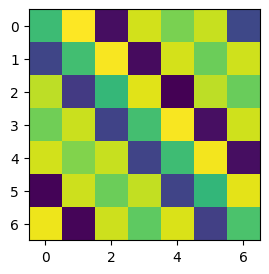

In [9]:
weight = torch.rand(size, size)

weight = weight.view(size**2)
weight = mlp.layers(weight)
weight = weight.view(size, size)

plt.figure(figsize=(3,3))
plt.imshow( weight.detach().cpu().numpy() )
plt.show()


<Axes: xlabel='method'>

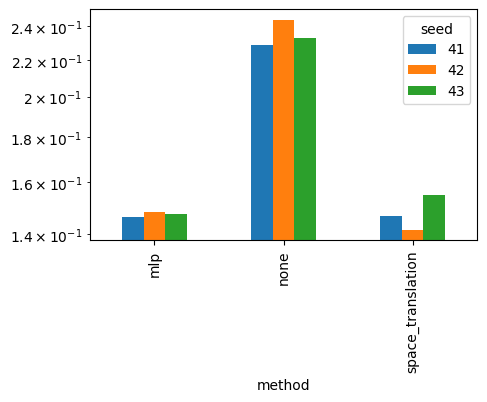

In [10]:
results = pd.DataFrame(rs)
results = results.set_index(['method']).sort_index()

results_testloss = results.pivot(columns = 'seed', values = 'test_loss')
results_losses = results.pivot(columns = 'seed', values = 'losses')

results_testloss.plot(kind = 'bar', figsize = (5, 3), logy=True)

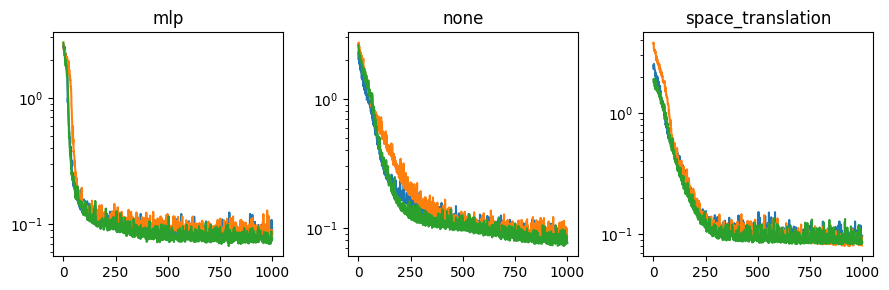

In [11]:
n_plots = len(results_losses)
fig, axs = plt.subplots(1, n_plots, figsize = (3*n_plots, 3), tight_layout = True)
for ax, (method, losses) in zip(axs, results_losses.iterrows()):
    for losses_i in losses:
        ax.plot(losses_i)
        ax.set_yscale('log')
    ax.set_title(method)

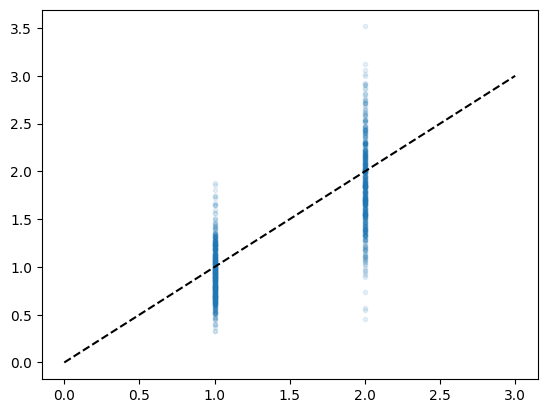

In [12]:
l_min, l_max = 0, 3
plt.plot(torch.cat(y_trues), torch.cat(y_preds), '.', alpha = 0.1)
plt.plot([l_min, l_max], [l_min, l_max], 'k--')
